<a href="https://colab.research.google.com/github/maderix/python_ray_tracing/blob/master/numpy_raytracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numy based raytracer in Python
As seen in the last version of the python raytracer, python is really slow for making a raytracer if we simulated each ray using python code.

To get around this problem, we use numpy to basically verctorize the whole function. So instead of operating on each pixel, we operate on arrays. This results in a massive speed up comapred to the naive non-vectorized version. 
Since all the numpy array operations are done natively, the speed is similar to a C/C++ version.

This version supports multi-bounce reflections, diffuse and specular shading. An effort to include transparency was made but due to some bug it isn't working correctly. 
One disadvantage of a a vectorized version is the difficulty in debugging , hence I'm leaving this as it is. If somebody can figure out the bug in refraction code, just fork and make changes to this notebook or submit a pull request on github. 


I've adapted most of the code from this link: http://www.excamera.com/sphinx/article-ray.html .

This ray tracer is missing lots of useful features but this could be used a good proof of concept for vectorized ray tracing.
A similar GPU based implementation using cupy is available [here](https://gist.github.com/maderix/bf605280bdddfd6354dd0d06fe6efead) but it seems to run much slower than this version. That is another research direction which can be tried. 
Have fun :)


In [0]:
# -*- coding: utf-8 -*-
# Commented out IPython magic to ensure Python compatibility.
from PIL import Image
from functools import reduce
import numpy as np
import numpy as onp
import time
import numbers
import math
import matplotlib.pyplot as plt
import cv2
%matplotlib inline


In [0]:
def extract(cond, x):
    if isinstance(x, numbers.Number):
        return x
    else:
        return np.extract(cond, x)

class vec3():
    def __init__(self, x, y, z):
        (self.x, self.y, self.z) = (x, y, z)
    def __mul__(self, other):
        return vec3(self.x * other, self.y * other, self.z * other)
    def __add__(self, other):
        return vec3(self.x + other.x, self.y + other.y, self.z + other.z)
    def __sub__(self, other):
        return vec3(self.x - other.x, self.y - other.y, self.z - other.z)
    def dot(self, other):
        return (self.x * other.x) + (self.y * other.y) + (self.z * other.z)
    def __abs__(self):
        return self.dot(self)
    def norm(self):
        mag = np.sqrt(abs(self))
        return self * (1.0 / np.where(mag == 0, 1, mag))
    def negate(self):
        self.x = self.x*-1
        self.y = self.y*-1
        self.z = self.z*-1
    def components(self):
        return (self.x, self.y, self.z)
    def copy(self):
        return vec3(np.array(self.x),np.array(self.y),np.array(self.z))
    def extract(self, cond):
        return vec3(extract(cond, self.x),
                    extract(cond, self.y),
                    extract(cond, self.z))
    def place(self, cond):
        r = vec3(np.zeros(cond.shape), np.zeros(cond.shape), np.zeros(cond.shape))
        np.place(r.x, cond, self.x)
        np.place(r.y, cond, self.y)
        np.place(r.z, cond, self.z)
        return r
rgb = vec3

In [0]:
(w, h) = (1920, 1080)         # Screen size
eye_pos = vec3(0.0, 5, -20)     # Eye position
FARAWAY = math.inf          # an implausibly huge distance
MAX_BOUNCE = 3             #maximum recursion level allowed
def mix(a,b,mix):
    return b*mix + a*(1-mix)

def raytrace(O, D, scene, bounce,lights):
    # O is the ray origin, D is the normalized ray direction
    # scene is a list of Sphere objects (see below)
    # bounce is the number of the bounce, starting at zero for camera rays

    distances = [s.intersect(O, D) for s in scene]
    nearest = reduce(np.minimum, distances)
    color = rgb(0.0, 0.0, 0.0)
    for (s, d) in zip(scene, distances):
        hit = (nearest != FARAWAY) & (d == nearest)
        if np.any(hit):
            dc = extract(hit, d)
            Oc = O.extract(hit)
            Dc = D.extract(hit)
            cc = s.light(Oc, Dc, dc, scene, bounce, lights)
            color += cc.place(hit)
    return color

In [0]:
class Sphere:
    def __init__(self, center, r, diffuse,roughness_coeff=50, mirror = 0.5,transmission=0.0,ior=1.1):
        self.c = center
        self.r = r
        self.diffuse = diffuse
        self.mirror = mirror
        self.transmission = transmission
        self.ior = ior
        self.roughness_coeff = roughness_coeff

    def intersect(self, O, D):
        b = 2 * D.dot(O - self.c)
        c = abs(self.c) + abs(O) - 2 * self.c.dot(O) - (self.r * self.r)
        disc = (b ** 2) - (4 * c)
        sq = np.sqrt(np.maximum(0, disc))
        h0 = (-b - sq) / 2
        h1 = (-b + sq) / 2
        h = np.where((h0 > 0) & (h0 < h1), h0, h1)
        pred = (disc > 0) & (h > 0)
        return np.where(pred, h, FARAWAY)
 
    def diffusecolor(self, M):
        return self.diffuse
 
    def light(self, O, D, d, scene, bounce, lights):
      # Ambient
      color = rgb(0.0,0.0,0.0)
      for L in lights:
        color += L[1]
        M = (O + D * d)                         # intersection point
        N = ((M - self.c) * (1. / self.r))        # normal
        toL = (L[0] - M).norm()                    # direction to light
        toO = (eye_pos - M).norm()                    # direction to ray origin
        nudged = M + N * .0001                  # M nudged to avoid itself
        # Shadow: find if the point is shadowed or not.
        # This amounts to finding out if M can see the light
        light_distances = [s.intersect(nudged, toL) for s in scene]
        light_nearest = reduce(np.minimum, light_distances)
        seelight = light_distances[scene.index(self)] == light_nearest
        # Lambert shading (diffuse)
        lv = np.maximum(N.dot(toL), 0)
        color += self.diffusecolor(M) * lv * seelight
        # Blinn-Phong shading (specular)
        phong = N.dot((toL + toO).norm())
        color += rgb(1,1,1)*np.power(np.clip(phong, 0, 1), self.roughness_coeff) * seelight
        # Reflection
        if bounce < MAX_BOUNCE:
            facing_ratio = -1.0*D.dot(N)
            F = mix(np.power(1 - facing_ratio, 3), 1, 0.1) #fresnel cofficient
            refraction = rgb(0,0,0)
            reflection = rgb(0,0,0)
            if self.mirror > 0:
                refl_dir = (D - N * 2 * D.dot(N)).norm()
                reflection = raytrace(nudged, refl_dir, scene, bounce + 1,lights) * (self.mirror/(bounce+1))
            #refraction (doesn't work for now)
            if self.transmission > 0:
                np.where(D.dot(N)>0,N,N.negate())
                eta = np.where(D.dot(N) > 0,self.ior,1/self.ior )
                nudged = M-N*.0001
                cos_i = D.dot(N)
                k = np.abs(1 + eta*eta * (cos_i*cos_i - 1))
                refr_dir = (D * eta - N*(eta*cos_i + np.sqrt(k) )).norm()
                refraction = raytrace(nudged, refr_dir, scene, bounce + 1,lights) * (self.transmission/(bounce+1))
            color +=  (reflection * (F) + refraction*(1-F))
      return color
 
class CheckeredSphere(Sphere):
    def diffusecolor(self, M):
        checker = ((M.x * 2).astype(int) % 2) == ((M.z * 2).astype(int) % 2)
        return self.diffuse * checker
 
scene = [
    Sphere(vec3(0.65, .1, 1.5), .6, rgb(0.9, 0.0, 0.0),500,0.2,0.0,ior = 1.1),
    Sphere(vec3(0.05, .1, -0.5), .6, rgb(0.6, 0.6, 0.6),500,0.2,0.0,1.1),
    Sphere(vec3(1.25, .1, 3.95), .6, rgb(0.3, 0.1, 0.3),500,0.1,0.0,1.4),
    Sphere(vec3(-0.15, .1, 3.95), .6, rgb(0.1, 0.1, 0.3),500,0.1,0.0,1.5),
    Sphere(vec3(-1.55, .1, 3.95), .6, rgb(0.1, 0.1, 0.1),500,0.1,0.0,1.01),
    Sphere(vec3(-0.55, .1, 1.5), .6, rgb(0.9, 0, 0),40,0.1,0.0,1.1),
    #CheckeredSphere(vec3(0,-99999.5, 0), 99999, rgb(.25, .25, .25),200, 0.5, 0.0, 1.1),
    Sphere(vec3(0,-99999.5, 0), 99999, rgb(0.5, 0.5, 0.5),50, 0.5),
    ]
#point lights
lights = [
          (vec3(0, 10, -20),rgb(0.001,0.001,0.001)),
          (vec3(10, 100, 30),rgb(0.002,0.002,0.002)),
          #(vec3(-10, 50, 30),rgb(0.00001,0.00001,0.00001))
]

Took 18.507310390472412


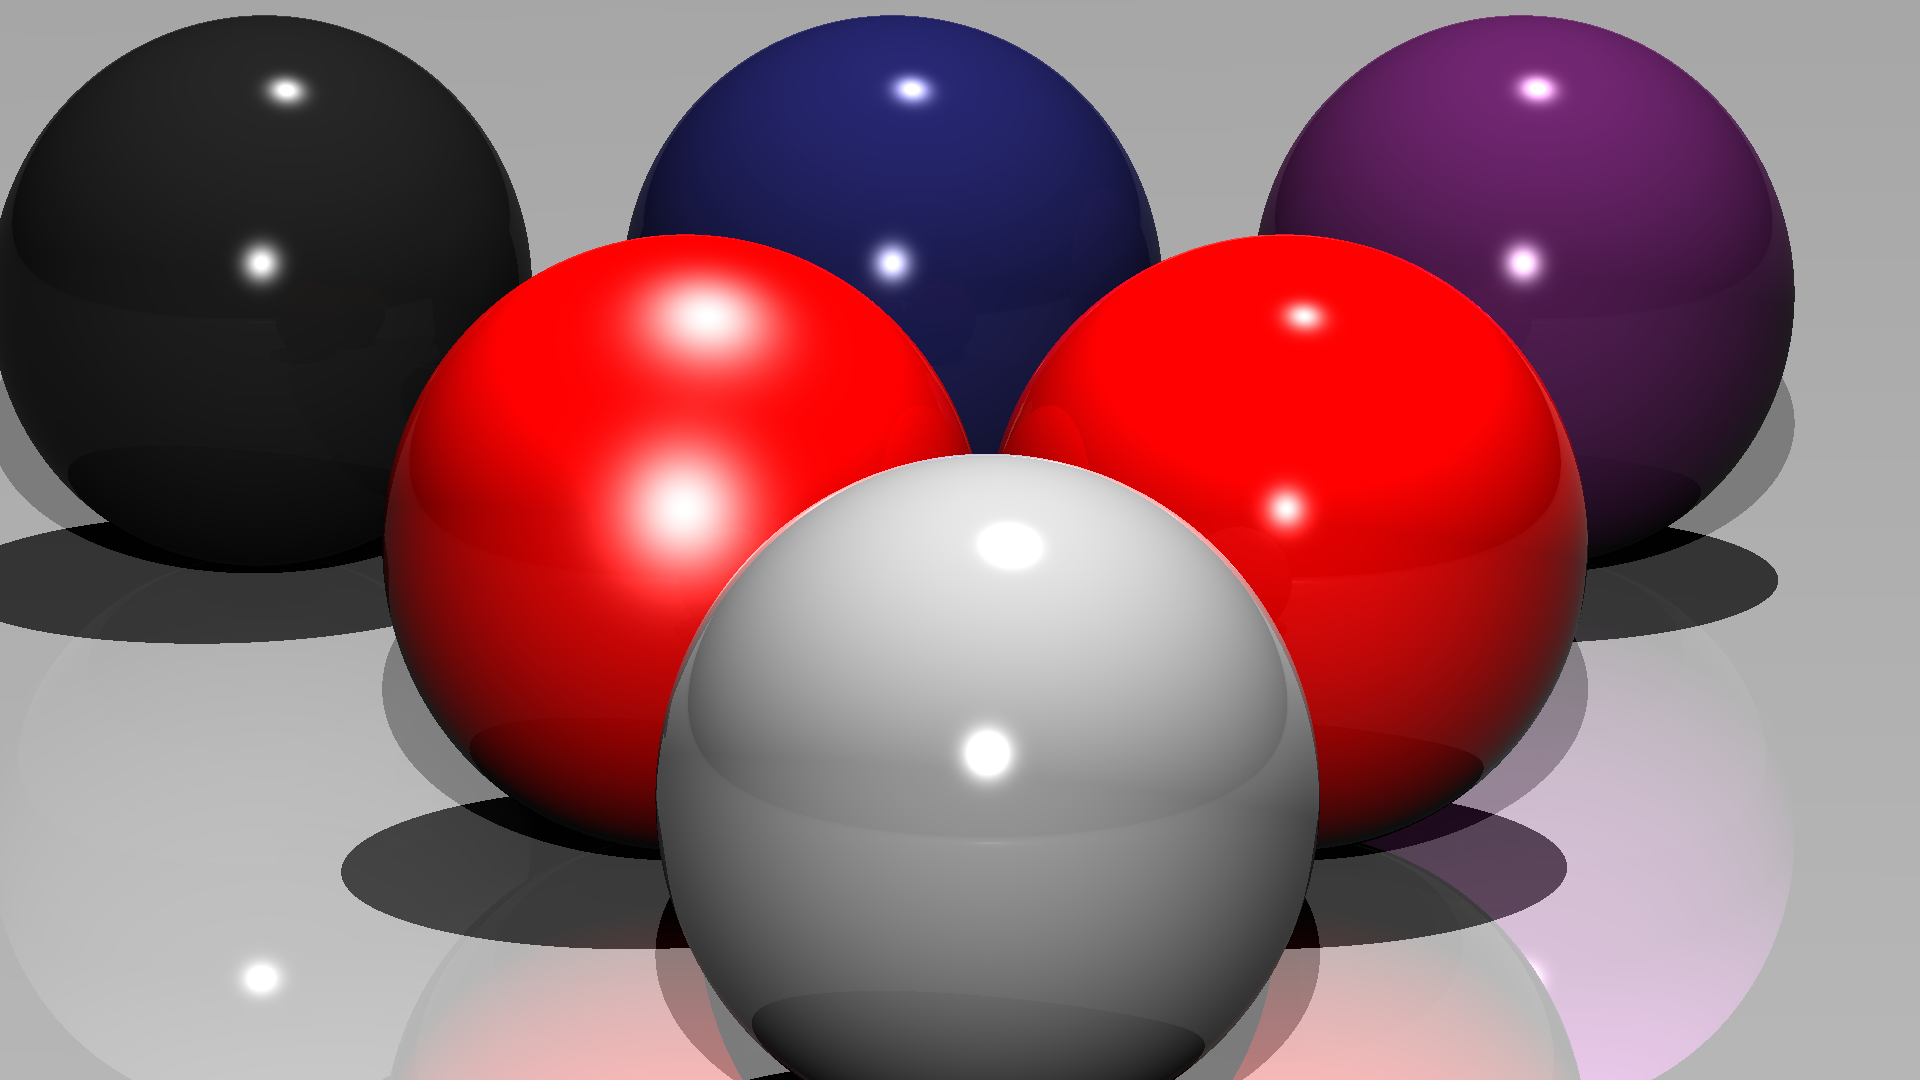

In [21]:
from IPython.display import Image, display
r = float(w) / h
fov=90
# Screen coordinates: x0, y0, x1, y1.
angle = math.tan(math.pi*0.5*fov/180)
S = (-1, 1 / r + .25, 1, -1 / r + .25)
x = np.tile(np.linspace(S[0], S[2], w)*r, h)
y = np.repeat(np.linspace(S[1], S[3], h)*r, w)
 
t0 = time.time()
Q = vec3(x, y, 0)
color = raytrace(eye_pos, (Q - eye_pos).norm(), scene,bounce=0,lights=lights)
print ("Took", time.time() - t0)
pixels = [(onp.clip(c,0,1).reshape((h, w))).astype(onp.float32) for c in color.components()]
pixels = onp.dstack((pixels[0],pixels[1],pixels[2]))
pixels = cv2.cvtColor(pixels,cv2.COLOR_BGR2RGB)
#pixels = Image.merge("RGB", pixels)
#plt.imshow(pixels)
cv2.imwrite("rt.png", 255*pixels)
display(Image("rt.png"))